<a href="https://colab.research.google.com/github/KudratBatta/Fake-Real-News-Prediction/blob/main/RealFake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kudratbatta","key":"452c4f0f7aeea8d258f9cdfb0cf0ffbd"}'}

In [3]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
!unzip fake-and-real-news-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
  0% 0.00/41.0M [00:00<?, ?B/s]
100% 41.0M/41.0M [00:00<00:00, 1.12GB/s]
Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

In [69]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

print("🚀 Streamlined Fake News Detection")
print("=" * 40)

print("📊 Loading data...")
fake_news = pd.read_csv('Fake.csv')
real_news = pd.read_csv('True.csv')

# Add labels and combine
fake_news['label'] = 0  # Fake
real_news['label'] = 1  # Real
df = pd.concat([fake_news, real_news], ignore_index=True)

print(f"✅ Loaded {len(df)} articles ({len(fake_news)} fake, {len(real_news)} real)")


🚀 Streamlined Fake News Detection
📊 Loading data...
✅ Loaded 44898 articles (23481 fake, 21417 real)


In [70]:
print("🔄 Preprocessing text...")

def preprocess_text(text):
    """Clean and preprocess text"""
    if pd.isna(text):
        return ""

    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

🔄 Preprocessing text...


In [71]:
df['combined_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# Remove empty texts
df = df[df['processed_text'].str.len() > 0]

print(f"✅ Preprocessing complete. Final dataset: {len(df)} articles")

✅ Preprocessing complete. Final dataset: 44898 articles


In [72]:
print("📈 Preparing features...")

X = df['processed_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} | Test set: {len(X_test)}")
print("🔤 Creating TF-IDF features...")

tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"✅ Created {X_train_tfidf.shape[1]} features")


📈 Preparing features...
Training set: 35918 | Test set: 8980
🔤 Creating TF-IDF features...
✅ Created 10000 features


In [73]:
print("🎯 Training Logistic Regression model...")

model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=1.0,
    solver='liblinear'
)

model.fit(X_train_tfidf, y_train)

🎯 Training Logistic Regression model...


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [74]:
print("🔮 Making predictions...")

y_pred = model.predict(X_test_tfidf)
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

🔮 Making predictions...



🎯 Model Performance:
Accuracy: 0.9895 (99.0%)

📊 Classification Report:
              precision    recall  f1-score   support

   Fake News       0.99      0.99      0.99      4696
   Real News       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



Text(0.5, 1.0, 'Confusion Matrix')

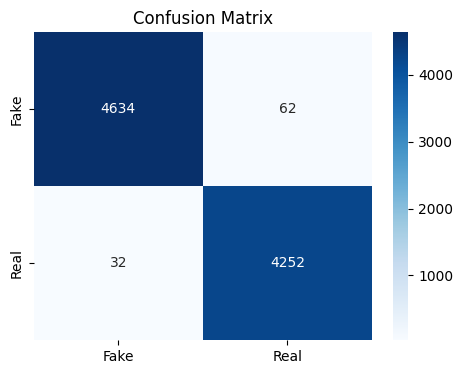

In [75]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Model Performance:")
print(f"Accuracy: {accuracy:.4f} ({accuracy:.1%})")

print(f"\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake News', 'Real News']))

plt.figure(figsize=(12, 4))

# Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')


In [80]:
def predict_news(text):
    """Predict if news is fake or real"""
    # Preprocess
    processed = preprocess_text(text)

    # Vectorize
    text_vector = tfidf.transform([processed])

    # Predict
    prediction = model.predict(text_vector)[0]
    probability = model.predict_proba(text_vector)[0]

    result = 'Real News' if prediction == 1 else 'Fake News'
    confidence = probability[prediction]

    return result, confidence

In [78]:
print("🔍 Top distinguishing features:")

# Get feature names and coefficients
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_[0]

# Check if model was trained successfully
if not hasattr(model, 'coef_'):
    print("❌ Model not trained properly. Please run the training section first.")
else:
    print(f"✅ Model has {len(coefficients)} feature coefficients")

# Top features for real news
top_real_indices = np.argsort(coefficients)[-10:]
print("\n📰 Top words indicating REAL news:")
for i in top_real_indices:
    print(f"  {feature_names[i]}: {coefficients[i]:.3f}")

# Top features for fake news
top_fake_indices = np.argsort(coefficients)[:10]
print("\n🚫 Top words indicating FAKE news:")
for i in top_fake_indices:
    print(f"  {feature_names[i]}: {coefficients[i]:.3f}")


🔍 Top distinguishing features:
✅ Model has 10000 feature coefficients

📰 Top words indicating REAL news:
  friday: 4.028
  thursday: 4.214
  washington: 4.458
  reuters president: 4.464
  tuesday: 4.612
  wednesday: 4.927
  president donald: 5.611
  washington reuters: 9.527
  said: 17.157
  reuters: 23.652

🚫 Top words indicating FAKE news:
  video: -8.937
  image: -8.310
  hillary: -5.645
  gop: -5.600
  obama: -5.366
  president trump: -5.237
  like: -4.364
  america: -4.275
  american: -4.240
  wire: -3.989


In [84]:
# Debug the model
print("🔍 Model Debugging:")
print(f"Training accuracy: {model.score(X_train_tfidf, y_train):.3f}")
print(f"Test accuracy: {model.score(X_test_tfidf, y_test):.3f}")

# Check prediction distribution
train_pred = model.predict(X_train_tfidf)
print(f"Training predictions - Real: {(train_pred == 1).sum()}, Fake: {(train_pred == 0).sum()}")

test_pred = model.predict(X_test_tfidf)
print(f"Test predictions - Real: {(test_pred == 1).sum()}, Fake: {(test_pred == 0).sum()}")

🔍 Model Debugging:
Training accuracy: 0.993
Test accuracy: 0.990
Training predictions - Real: 17165, Fake: 18753
Test predictions - Real: 4314, Fake: 4666


In [86]:
real_example = """
WASHINGTON - President Biden announced Wednesday that the United States will provide an additional $2 billion in military aid to Ukraine, according to a White House statement. The package includes advanced missile systems and artillery rounds, bringing total U.S. aid to $113 billion since the conflict began in February 2022.
"""
pred1, conf1 = predict_news(real_example)

print(f"Real example: {pred1} (confidence: {conf1:.3f})")

Real example: Real News (confidence: 0.754)


In [87]:
fake_example = """
BREAKING: Deep state operatives caught red-handed manipulating vote counts in swing states! Exclusive footage shows mysterious boxes being moved at 3 AM. The mainstream media is completely silent about this MASSIVE scandal that could change everything!
"""
pred2, conf2 = predict_news(fake_example)
print(f"Fake example: {pred2} (confidence: {conf2:.3f})")

Fake example: Fake News (confidence: 0.970)
